In [36]:
# import relevant modules
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import time
import sys
%matplotlib inline

from scipy.special import (i1, i0, hyp1f1)
from scipy.optimize import brentq
from dipy.core.sphere import disperse_charges, HemiSphere
from dipy.core.gradients import gradient_table
from dipy.sims.voxel import multi_tensor
import dipy.reconst.dti as dti
import dipy.reconst.dki as dki

from dipy.sims.voxel import (multi_tensor, _add_gaussian, _add_rician,
                             _add_rayleigh)

from pca_utils import (rfiw_phantom, mp_distribution,
                       fiber_segments_phantom, evaluate_directions,
                       evaluate_metric, pca_noise_classifier,
                       pca_denoising)

In [2]:
# ---------------------------------------------------------------
# acquisition parameters
# ---------------------------------------------------------------

# Sample 8 diffusion-weighted directions for first shell
n_pts = 8
theta = np.pi * np.random.rand(n_pts)
phi = 2 * np.pi * np.random.rand(n_pts)
hsph_initial = HemiSphere(theta=theta, phi=phi)
hsph_updated, potential = disperse_charges(hsph_initial, 5000)
directions8 = hsph_updated.vertices  # directions for each shell

# Sample 30 diffusion-weighted directions for second shell
n_pts = 30
theta = np.pi * np.random.rand(n_pts)
phi = 2 * np.pi * np.random.rand(n_pts)
hsph_initial = HemiSphere(theta=theta, phi=phi)
hsph_updated, potential = disperse_charges(hsph_initial, 50000)
directions30 = hsph_updated.vertices  # directions for each shell

# Sample 60 diffusion-weighted directions for second shell
n_pts = 60
theta = np.pi * np.random.rand(n_pts)
phi = 2 * np.pi * np.random.rand(n_pts)
hsph_initial = HemiSphere(theta=theta, phi=phi)
hsph_updated, potential = disperse_charges(hsph_initial, 50000)
directions60 = hsph_updated.vertices  # directions for each shell

# Create full dataset parameters
bvals = np.hstack((np.zeros(6), 300 * np.ones(8),
                   1000 * np.ones(30), 2000 * np.ones(60)))
bvecs = np.vstack((np.zeros((6, 3)), directions8, directions30, directions60))
gtab = gradient_table(bvals, bvecs)

In [3]:
dtiM = dti.TensorModel(gtab)
dkiM = dki.DiffusionKurtosisModel(gtab)

In [4]:
fsigmas = np.array([40.0, 30.0, 20.0, 10.0])
dir1 = np.zeros(fsigmas.size)
dir2 = np.zeros(dir1.shape)
dir3 = np.zeros(dir1.shape)
fa1 = np.zeros(dir1.shape)
fa2 = np.zeros(dir1.shape)
fa3 = np.zeros(dir1.shape)
md1 = np.zeros(dir1.shape)
md2 = np.zeros(dir1.shape)
md3 = np.zeros(dir1.shape)
mk1 = np.zeros(dir1.shape)
mk2 = np.zeros(dir1.shape)
mk3 = np.zeros(dir1.shape)
sig1 = np.zeros(dir1.shape)
sig2 = np.zeros(dir1.shape)
sig3 = np.zeros(dir1.shape)
ncomps1 = np.zeros(dir1.shape)
ncomps2 = np.zeros(dir1.shape)
ncomps3 = np.zeros(dir1.shape)
meansig = np.zeros(4)

residual_all = np.zeros((10, 10, 10, bvals.size, fsigmas.size))

snr = 15
sigma = 50.0 /snr

for p in range(4):
    # ground truth is now the average of rician noise data
    Phantom = fiber_segments_phantom(gtab, fsigmas[p])

    n1 = np.random.normal(0, sigma, size=Phantom.shape)
    n2 = np.random.normal(0, sigma, size=Phantom.shape)
    Phantom_gt = _add_rician(Phantom.copy(), n1, n2)

    for rep in range(9):
        # add noise
        n1 = np.random.normal(0, sigma, size=Phantom.shape)
        n2 = np.random.normal(0, sigma, size=Phantom.shape)
        Phantom_gt = Phantom_gt + _add_rician(Phantom.copy(), n1, n2)
    Phantom_gt = Phantom_gt / 10
    
    dtiFgt = dtiM.fit(Phantom_gt)
    FAgt = dtiFgt.fa
    MDgt = dtiFgt.md 
    directionsgt = dtiFgt.directions
    dkiFgt = dkiM.fit(Phantom_gt)
    MKgt = dkiFgt.mk()

    # add noise
    n1 = np.random.normal(0, sigma, size=Phantom.shape)
    n2 = np.random.normal(0, sigma, size=Phantom.shape)
    Phantom_noise = _add_rician(Phantom.copy(), n1, n2)

    # denoise and compare
    [Pden, sig, ncomps] = pca_denoising(Phantom_noise.copy(), ps=2, overcomplete=True)
    dtiF = dtiM.fit(Pden)
    FA = dtiF.fa
    MD = dtiF.md
    directions = dtiF.directions
    dkiF = dkiM.fit(Pden)
    MK = dkiF.mk()
    p1, p2, p3 = evaluate_directions(directions[2:-2, 2:-2, 2:-2], directionsgt[2:-2, 2:-2, 2:-2])
    dir1[p] = p1
    dir2[p] = p2
    dir3[p] = p3
    p1, p2, p3 = evaluate_metric(FA[2:-2, 2:-2, 2:-2], FAgt[2:-2, 2:-2, 2:-2])
    fa1[p] = p1
    fa2[p] = p2
    fa3[p] = p3
    p1, p2, p3 = evaluate_metric(MD[2:-2, 2:-2, 2:-2], MDgt[2:-2, 2:-2, 2:-2])
    md1[p] = p1
    md2[p] = p2
    md3[p] = p3
    p1, p2, p3 = evaluate_metric(MK[2:-2, 2:-2, 2:-2], MKgt[2:-2, 2:-2, 2:-2])
    mk1[p] = p1
    mk2[p] = p2
    mk3[p] = p3
    p1, p2, p3 = np.percentile(sig[2:-2, 2:-2, 2:-2], [25, 50, 75])
    sig1[p] = p2
    sig2[p] = p2 - p1
    sig3[p] = p3 - p2
    p1, p2, p3 = np.percentile(ncomps[2:-2, 2:-2, 2:-2], [25, 50, 75])
    ncomps1[p] = p2
    ncomps2[p] = p2 - p1
    ncomps3[p] = p3 - p2
    residual_all[:, :, :, :, p] = Pden - Phantom_noise
    meansig[p] = np.mean(Phantom)
    print meansig[p]

19.0113812418
19.0118642257
19.0116738693
19.013564299


First lets analyse the estimated sigma to analyse how to correct it

C:\Users\Rafael\Anaconda\lib\site-packages\matplotlib\collections.py:590: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


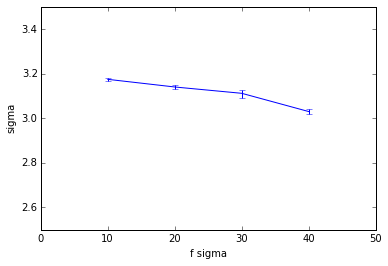

In [5]:
plt.errorbar(fsigmas, sig1, yerr=[sig2, sig3])
plt.axis([0, 50, 2.5, 3.5])
plt.xlabel('f sigma')
plt.ylabel('sigma')
fig = matplotlib.pyplot.gcf()
plt.show()

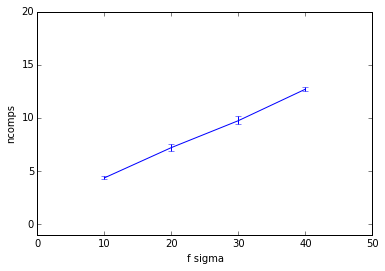

In [6]:
plt.errorbar(fsigmas, ncomps1, yerr=[ncomps2, ncomps3])
plt.axis([0, 50, -1, 20])
plt.xlabel('f sigma')
plt.ylabel('ncomps')
fig = matplotlib.pyplot.gcf()
plt.show()

In [7]:
def std2rician(esig, mstd):
    """
    Converts signal standard deviation of signal corrupted by
    Rician noise to the standard deviation of the rician distribution

    Parameters
    ----------
    esig : array
        Rician expected mean signal corrupted by rician noise
    mstd : array
        Measured signal Standard deviation corrupted by rician noise

    Returns
    -------
    sig : array
       Standard deviation of the rician distribution
    """
    SNR2 = (esig / mstd) ** 2
    # estimate correction factor
    fact = 2.0 + SNR2 - np.pi/8.0 * np.exp(-SNR2/2.0) * \
           ((2+SNR2) * i0(SNR2/4.0) + SNR2*i1(SNR2/4.0)) ** 2
    sig = esig / fact

In [8]:
snr = meansig/sigma
SNR2 = snr**2
fact = 2.0 + SNR2 - np.pi/8.0 * np.exp(-SNR2/2.0) * \
           ((2+SNR2) * i0(SNR2/4.0) + SNR2*i1(SNR2/4.0)) ** 2

In [9]:
fact

array([ 0.98410928,  0.98411011,  0.98410978,  0.98411306])

In [10]:
sigma

3.3333333333333335

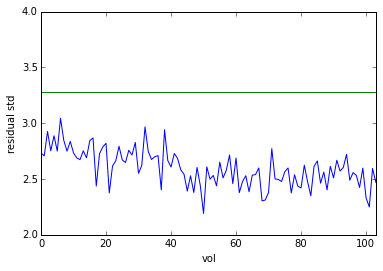

3.2803642595
3.02986629474
3.07879049912
2.59967163918


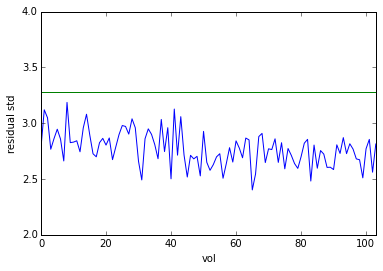

3.28036704843
3.11154168594
3.16178204045
2.77148364632


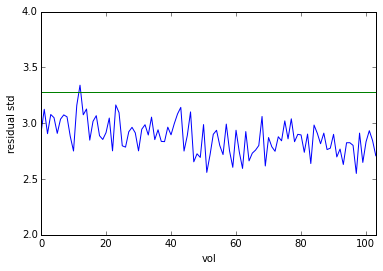

3.28036594927
3.13986058522
3.19055925851
2.87789318704


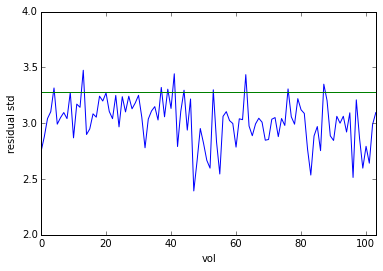

3.28037686352
3.1741288606
3.2253701253
3.01749753592


In [11]:
resi = np.zeros(4)
for p in range(4):
    vol_std = np.zeros(104)
    for v in range(104):
        vol_std[v] = np.std(residual_all[2:-2, 2:-2, 2:-2, v, p], ddof=1)
    plt.plot(vol_std)
    plt.plot([0, 103], [sigma*fact[p], sigma*fact[p]])
    plt.axis([0, 103, 2, 4])
    plt.xlabel('vol')
    plt.ylabel('residual std')
    fig = matplotlib.pyplot.gcf()
    plt.show()

    print sigma * fact[p]
    print sig1[p]
    print sig1[p] / fact[p]
    print np.mean(vol_std)
    resi[p] = np.mean(vol_std)

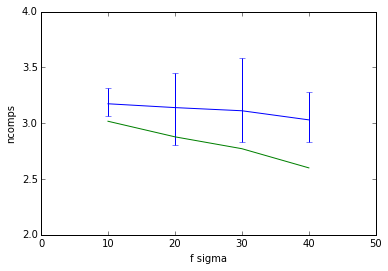

In [12]:
plt.errorbar(fsigmas, sig1, yerr=[ncomps2, ncomps3])
plt.plot(fsigmas, resi)
plt.axis([0, 50, 2, 4])
plt.xlabel('f sigma')
plt.ylabel('ncomps')
fig = matplotlib.pyplot.gcf()
plt.show()

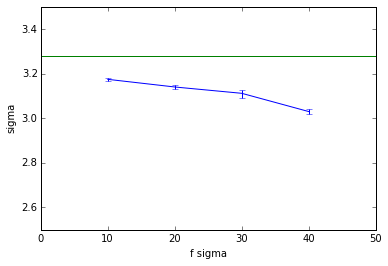

In [13]:
plt.errorbar(fsigmas, sig1, yerr=[sig2, sig3])
plt.plot([0, 50], [sigma*fact[0], sigma*fact[0]])
plt.axis([0, 50, 2.5, 3.5])
plt.xlabel('f sigma')
plt.ylabel('sigma')
fig = matplotlib.pyplot.gcf()
plt.show()

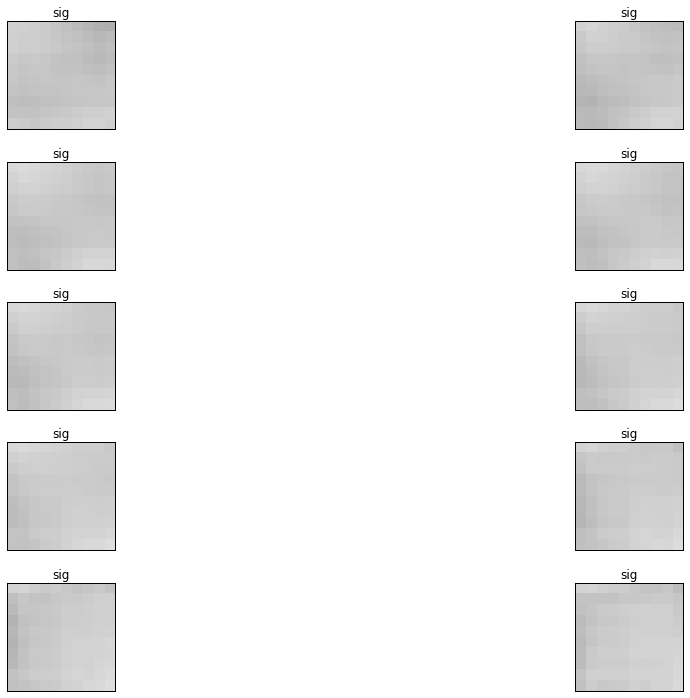

In [14]:
fig2, ax = plt.subplots(5, 2, figsize=(18, 12),
                        subplot_kw={'xticks': [], 'yticks': []})

fig2.subplots_adjust(hspace=0.3, wspace=0.3)

vol = 0
for i in range(10):
    ax.flat[i].imshow(sig[:, :, i], cmap='gray', interpolation="nearest", clim=(2.7, 3.3))
    ax.flat[i].set_title('sig')
plt.show()

In [20]:
def _normalized_rician_expected_value(snr):
    """
    Computes the rician expected intensity normalized by the
    noise standard deviation given the signal ground truth.

    Parameters
    ----------
    signal : array
        Containing ground truth signal to convert to expected values
    sigma : float or array
        Containing ground truth sigma

    Returns
    -------
    esignal : array
       Rician expected values for the given ground truth signals
    """
    return np.sqrt(0.5*np.pi) * hyp1f1(-0.5, 1.0, -0.5*(snr)**2)

In [24]:
def rician_expected_value(signal, sigma):
    """
    Computes the rician expected intensity given the noise free
    signal and the noise standard deviation.

    Parameters
    ----------
    signal : array
        Containing ground truth signal to convert to expected values
    sigma : float or array
        Containing ground truth sigma

    Returns
    -------
    esignal : array
       Rician expected values for the given ground truth signals
    """
    return sigma * _normalized_rician_expected_value(signal*1.0/sigma)

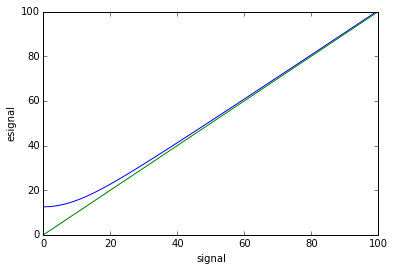

In [30]:
signal = np.array(range(10000))
sigma = 10
esignal = rician_expected_value(signal, sigma)
plt.plot(signal, esignal)
plt.plot(signal, signal)
plt.axis([0, 100, 0, 100])
plt.xlabel('signal')
plt.ylabel('esignal')
plt.show()

In [43]:
def _rician_error(snr, esnr):
    return esnr - _normalized_rician_expected_value(snr)

In [55]:
def rician_gt_value(esignal, sigma):
    """
    Computes the noise free intensity given the rician biases signal
    and the ground truth noise standard deviation.

    Parameters
    ----------
    esignal : array
        Containing rician biased signal
    sigma : float or array
        Containing ground truth sigma

    Returns
    -------
    esigma : array
       Ground truth bias free signal
    """
    esnrmin = _normalized_rician_expected_value(0)
    esnr = esignal * 1.0/ sigma
    if esnr < esnrmin:
        snr = 0
    else:
        snr = brentq(_rician_error, 0, esignal * 1.0/ sigma, args=(esignal * 1.0/ sigma))
    return snr * sigma

In [37]:
esignal = rician_expected_value(signal, sigma)

100
100.501269367


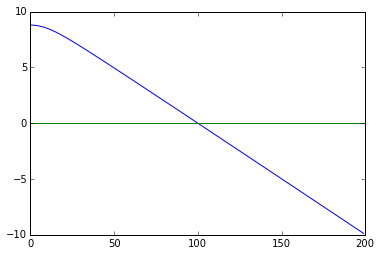

In [47]:
print signal[100]
print esignal[100]
er = _rician_error(signal[:200]*1.0/sigma, esignal[100]/sigma)
plt.plot(er)
plt.plot(np.zeros(er.shape))
plt.show()

As required by the convergence function two extremes have opposite signs 

In [60]:
i = 1
print esignal[i]
print rician_gt_value(esignal[i], sigma)

12.5644546599
1.0
